# Loan Approval Prediction, a classification problem

### How accurate will we be predicting determinations for loan approval requests?

In [ ]:
# Dataset location - https://www.kaggle.com/shaijudatascience/loan-prediction-practice-av-competition

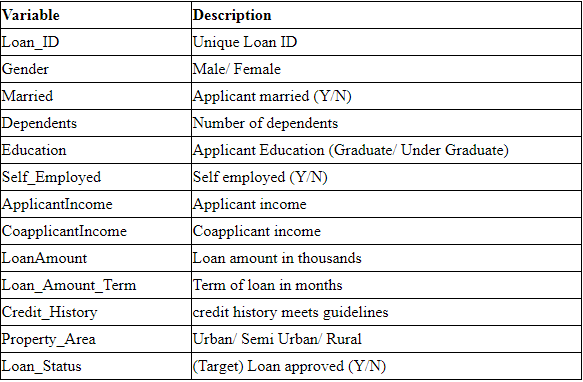

In [5]:
from IPython.display import Image

Image(filename='../images/loan_variables.png')

In [ ]:
# There are 13 variables in the dataset.
# 'Loan_Status' is our target; we are attempting to predict loan approvals.
# To address any potential for data leakage, we will refrain from creating 
# any new features using the target, we won't perform any fitting using our 
# validation sets, and we will watch for any significant declines in our 
# models' performance when scoring our validation sets. 

# Notebook Index

- `Part I, Imports & EDA`
 
- `Part II, Wrangle Data`
  
- `Part III, Split the Data`
    
- `Part IV, Establish a Baseline`

- `Part V, Build Models`
    `-`
   - `LogisticRegression`
   - `RandomForestClassifier` 
   - `XGBoostClassifier`

- `Part VI, Check Metrics`
    `-`
   - `Models, Scores`
   - `Cross Validation Scores`
   - `Confusion Matrices/Precision & Recall`
   - `ROC Curve`

- `Part VII, Tune Models & Recheck Metrics`

# I. Imports & EDA 

In [524]:
# Import packages and package classes

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, plot_roc_curve, roc_auc_score, plot_confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

In [176]:
# It's a small dataset, but > the threshold of 500 observations.

train = pd.read_csv('../data/class-project/LoanApproval/train_data.csv')

print(train.shape)
train.head()

(614, 13)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [177]:
# The target vector is 'Loan_Status'

# The classes of the Target Vector are moderately imbalanced towards approval, but < 70%, we 
# can still look at model accuracy for scoring. 
# You have a 68.73% chance of being correct if you always decide that the loan was approved.

train['Loan_Status'].value_counts(normalize=True)

Y    0.687296
N    0.312704
Name: Loan_Status, dtype: float64

In [9]:
# There are a lot of categorical variables; there are NaN values in the dataset. 

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [11]:
# Examine the number of unique entries for variables.

for col in list(train.columns):
    print(col, train[col].nunique())

Loan_ID 614
Gender 2
Married 2
Dependents 4
Education 2
Self_Employed 2
ApplicantIncome 505
CoapplicantIncome 287
LoanAmount 203
Loan_Amount_Term 10
Credit_History 2
Property_Area 3
Loan_Status 2


In [12]:
# Examine 'Dependents' feature

print(train['Dependents'].unique())

['0' '1' '2' '3+' nan]


In [100]:
# Examine 'Property_Area' feature
# No missing values, implies either all loans are home/property purchases, or is
# indicating where loan applicant resides. 

print(train['Property_Area'].value_counts())

Semiurban    233
Urban        202
Rural        179
Name: Property_Area, dtype: int64


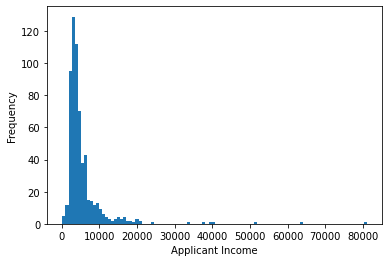

       ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
count       614.000000         614.000000  592.000000         600.00000   
mean       5403.459283        1621.245798  146.412162         342.00000   
std        6109.041673        2926.248369   85.587325          65.12041   
min         150.000000           0.000000    9.000000          12.00000   
25%        2877.500000           0.000000  100.000000         360.00000   
50%        3812.500000        1188.500000  128.000000         360.00000   
75%        5795.000000        2297.250000  168.000000         360.00000   
max       81000.000000       41667.000000  700.000000         480.00000   

       Credit_History  income_adj  
count      564.000000  614.000000  
mean         0.842199   54.034593  
std          0.364878   61.090417  
min          0.000000    1.500000  
25%          1.000000   28.775000  
50%          1.000000   38.125000  
75%          1.000000   57.950000  
max          1.000000  810.000000  


In [199]:
# Complete histogram plots of the continuous variables,
# and explore their distributions.

# Applicant Income
train['ApplicantIncome'].plot(kind='hist', bins=100)

plt.xlabel('Applicant Income')
plt.ylabel('Frequency')
plt.show();

print(train.describe())

# Possible outliers present.
# Also 'Applicant_Income' and 'Coapplicant_Income' may need to be addressed (scaled).  
# Information from dataset authorindicates 'LoanAmount' is in thousands.  This would 
# mean the min amount requested was $9,000, and the max loan request was $700,000.
# If the same scale is used for 'ApplicantIncome' it would indicate a low of
# $150,000, and a high of $81 million - a highly unlikely spread.  It would also
# imply a max 'CoapplicantIncome' of > $41 million!

In [186]:
train['income_adj'] = train['ApplicantIncome'] / 100

train['income_adj'].describe()

count    614.000000
mean      54.034593
std       61.090417
min        1.500000
25%       28.775000
50%       38.125000
75%       57.950000
max      810.000000
Name: income_adj, dtype: float64

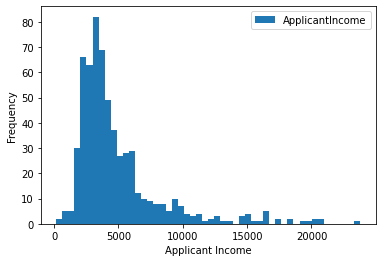

       ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
count       605.000000         605.000000  583.000000        591.000000   
mean       4906.877686        1512.712264  143.317324        342.741117   
std        3472.102471        2064.711468   78.533250         64.541662   
min         150.000000           0.000000    9.000000         12.000000   
25%        2876.000000           0.000000  100.000000        360.000000   
50%        3775.000000        1213.000000  127.000000        360.000000   
75%        5708.000000        2283.000000  165.000000        360.000000   
max       23803.000000       20000.000000  650.000000        480.000000   

       Credit_History  
count      556.000000  
mean         0.843525  
std          0.363632  
min          0.000000  
25%          1.000000  
50%          1.000000  
75%          1.000000  
max          1.000000  


In [91]:
# Explore removing outliers from 'ApplicantIncome' and 'CoapplicantIncome' are > $250,000.

explore = train[ (train['ApplicantIncome'] < 25_000) &
                 (train['CoapplicantIncome'] < 25_000)]

explore[['ApplicantIncome']].plot(kind='hist', bins=50)
plt.xlabel('Applicant Income')
plt.ylabel('Frequency')
plt.show();

print(explore.describe())

# Loss of 9 observations.

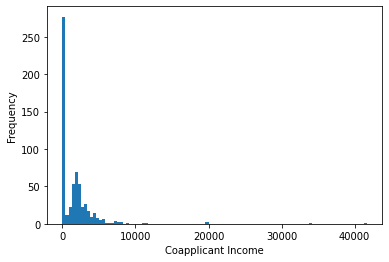

In [94]:
# Coapplicant Income

train['CoapplicantIncome'].plot(kind='hist', bins=100)

plt.xlabel('Coapplicant Income')
plt.ylabel('Frequency')
plt.show();

# Appears to have potential outliers on the high end of income.
# Zero income is not out-of-the-ordinary; there are many single income households.

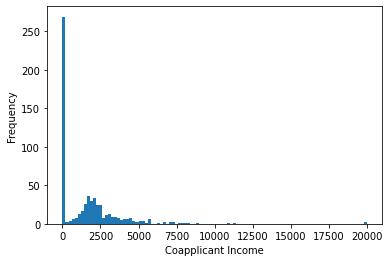

In [95]:
# Coapplicant Income, explore

explore['CoapplicantIncome'].plot(kind='hist', bins=100)

plt.xlabel('Coapplicant Income')
plt.ylabel('Frequency')
plt.show();

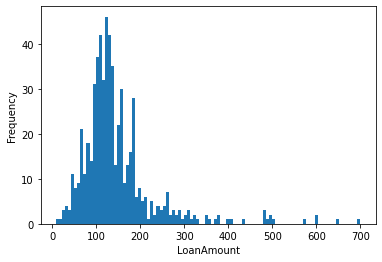

In [96]:
# Loan Amount

train['LoanAmount'].plot(kind='hist', bins=100)

plt.xlabel('LoanAmount')
plt.ylabel('Frequency')
plt.show();

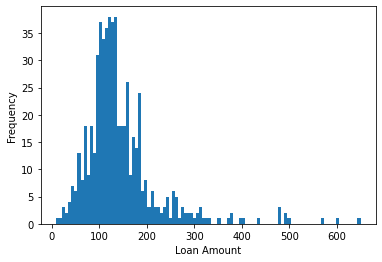

In [97]:
# Loan Amount, explore

explore['LoanAmount'].plot(kind='hist', bins=100)

plt.xlabel('Loan Amount')
plt.ylabel('Frequency')
plt.show();

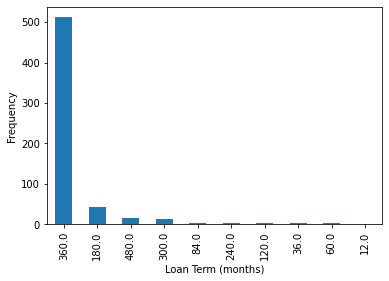

In [99]:
# Examine 'Loan_Amount_Term', listed as a float, really a categorical variable, 10 categories.

train['Loan_Amount_Term'].value_counts().plot(kind='bar')

plt.xlabel('Loan Term (months)')
plt.ylabel('Frequency')
plt.show();

# Primarily 30-year notes, likely mortgages. terms of 12-months might indicate a personal loan, 
# 3-year and 5-year durations are more typical with auto-lending.  What's odd, however, is that 
# every observation (all 614) have an input value for 'Property_Area' (urban, semi-urban, rural).
# Further clarification of the data would have been preferred. 

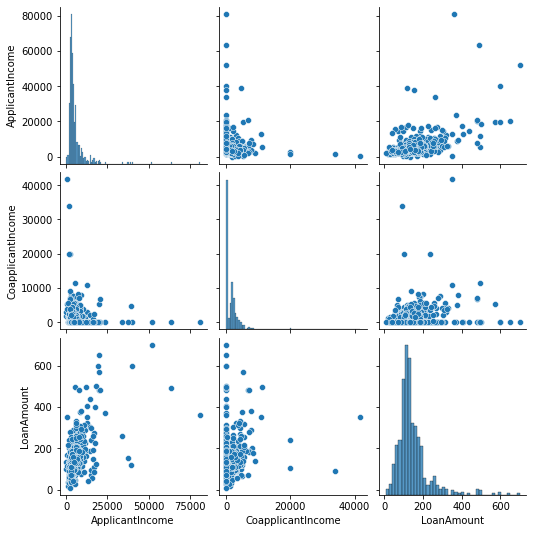

In [103]:
# Examine for correlation among continuous variables; possible outliers noted.

sns.pairplot(train[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']])
plt.show()

## Summary of Initial EDA

In [ ]:
# 'Loan_ID', high cardinality column, variable is a unique identifier and will be dropped.
# 'Gender', binary categorical variable, assignment == Male/Female, NaN objects hold no meaning.
# 'Married', binary categorical feature, assignment == Y/N, NaN objects hold no meaning.
# 'Dependents', categorical feature, assignment == 0/1/2/3+, NaN objects hold no meaning.
# 'Education', binary categorical feature, assignement == Graduate/Not Graduate, no NaN objects.
# 'Self-Employed', binary categorical feature, assignment = Y/N, NaN objects hold no meaning.
# 'ApplicantIncome', continuous numeric feature, possible outliers, NaN values without meaning.
# 'CoapplicantIncome', continuous numeric feature, possible outliers, NaN values without meaning.
# 'LoanAmount', continuous numeric feature, possible outliers, NaN values without meaning.
# 'Loan_Amount_Term', categorical variable, cardinality == 10, NaN values without meaning.
# 'Credit_History', binary categorical variable, assignment == 1/0, NaN values without meaning. 
# 'Proprty_Area', categorical variable, cardinality == 3, no NaN values. 

# II. Wrangle Data

In [1046]:
# Write wrangle function ... this is the accumulation of all prior work and exploration, for 
# best model fit without hyperparameter tuning. 

def wrangle(filepath):

    # Read in the data
    df = pd.read_csv('../data/class-project/LoanApproval/' + filepath)
    
    # Drop high-cardinality identifier column, 'Loan_ID'
    df.drop(columns='Loan_ID', inplace=True)
    
    # Cleanup column names
    df.columns = [col.lower() for col in df.columns]       
    df = df.rename(columns=
        {'applicantincome': 'applicant_income',
         'coapplicantincome': 'coapplicant_income',
         'loanamount': 'loan_amount'})
    
    # Fill NaN values with the mode of the feature it resides in ('most_frequent'); exception, 'loan_amount'
    mode_cols = ['gender', 'married', 'dependents', 'self_employed', 'loan_amount_term', 'credit_history']
    for col in mode_cols:
        df[col].fillna(value=df[col].mode()[0], inplace=True)
    
    # Drop remaining NaN values, all in 'loan_amount' column; difficult to predict without this information. 
    df.dropna(inplace=True)
    
    # Scale 'applicant_income' and 'coapplicant_income' to thousands
    df['applicant_income'] = df['applicant_income'] / 100
    df['coapplicant_income'] = df['coapplicant_income'] / 100
       
    # Convert 'credit_history' to binary categorical from float 
    df['credit_history'].replace(to_replace={1.0: '1', 0.0: '0'}, 
                                 inplace=True)
    
    # Convert 'loan_amount_term' to categorical variable (object) from float
    df['loan_amount_term'] = df['loan_amount_term'].astype(int).astype(str) 

    # Clean 'dependents' feature
    df['dependents'] = df['dependents'].str.strip('+')

    # Convert target, 'LoanStatus' to binary numeric values
    df['loan_status'].replace(to_replace={'Y': 1, 'N':0}, inplace=True) 
  
    # Creat 'loan_to_income' feature
    df['loan_to_income'] = df['loan_amount'] / (df['applicant_income'] + df['coapplicant_income'])

    # Remove the outliers where income is > $250,000
    df = df[ (df['applicant_income'] < 250) &
             (df['coapplicant_income'] < 250)]
    
    # Drop columns noted not to be helpful in predicting loan approval outcome
    df.drop(columns=['gender', 'education', 'coapplicant_income'], inplace=True)
    
    return df

train_path = 'train_data.csv'
train= wrangle(train_path)

In [1047]:
print(train.shape)
train.head()

(583, 10)


,married,dependents,self_employed,applicant_income,loan_amount,loan_amount_term,credit_history,property_area,loan_status,loan_to_income
1,Yes,1,No,45.83,128.0,360,1,Rural,0,2.101461
2,Yes,0,Yes,30.00,66.0,360,1,Urban,1,2.200000
3,Yes,0,No,25.83,120.0,360,1,Urban,1,2.428658
4,No,0,No,60.00,141.0,360,1,Urban,1,2.350000
5,Yes,2,Yes,54.17,267.0,360,1,Urban,1,2.777489


In [1048]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 583 entries, 1 to 613
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   married           583 non-null    object 
 1   dependents        583 non-null    object 
 2   self_employed     583 non-null    object 
 3   applicant_income  583 non-null    float64
 4   loan_amount       583 non-null    float64
 5   loan_amount_term  583 non-null    object 
 6   credit_history    583 non-null    object 
 7   property_area     583 non-null    object 
 8   loan_status       583 non-null    int64  
 9   loan_to_income    583 non-null    float64
dtypes: float64(3), int64(1), object(6)
memory usage: 50.1+ KB


In [1049]:
train.describe()

,applicant_income,loan_amount,loan_status,loan_to_income
count,583.000000,583.000000,583.000000,583.000000
mean,48.889966,143.317324,0.696398,2.400922
std,34.318403,78.533250,0.460208,0.808459
min,1.500000,9.000000,0.000000,0.301614
25%,28.855000,100.000000,0.000000,1.962545
50%,37.620000,127.000000,1.000000,2.428658
75%,57.030000,165.000000,1.000000,2.825673
max,238.030000,650.000000,1.000000,8.271164


# III. Split the Data

In [1050]:
# Create Feature Matrix and Target Array

target = 'loan_status'

y = train[target]
X = train.drop(columns=target)

In [1051]:
# Split the data
# Will use a random split; there is no datetime information included in this dataset.

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# IV. Establish a Baseline

In [1052]:
# The target vector is 'Loan_Status'
# The classes of the TV are moderately imbalanced towards approval, but < 70%, so we can still look at 
# model accuracy for scoring. 

# You have a 69.40% chance of being correct if you always decide that the loan was approved.
print('Baseline Accuracy for predicting Loan Approval: {:.2f}%'.format
      (y.value_counts(normalize=True).max()*100))


Baseline Accuracy for predicting Loan Approval: 69.64%


# V. Build Models

- `LogisticRegression`
    
    - `OneHotEncoder`
    - `StandardScaler`
 
- `RandomForrestClassifier`

    - `OrdinalEncoder`
    
- `XGBClassifier`

    - `OrdinalEncoder`

In [1053]:
# Model 1: Logistic Regression Model

model_lr = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    StandardScaler(),
    LogisticRegression()
)

model_lr.fit(X_train, y_train);

/Users/frankhowd/.local/share/virtualenvs/DS-Unit-2-Applied-Modeling-YelssOLa/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [1054]:
# Model 2: Random Forest Classifier Model

model_rf = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier(n_jobs=-1, random_state=42)
)

model_rf.fit(X_train, y_train);

In [1055]:
# Model 3: XG-Boost Classifier

model_xgb = make_pipeline(
    OrdinalEncoder(),
    XGBClassifier(random_state=42, n_jobs=-1)
)

model_xgb.fit(X_train, y_train);

# VI. Check Metrics

In [1015]:
# Training and Validation accuracy of our Logistic Regression model

print('Training Accuracy (LOGR): {:.2f}%'.format(model_lr.score(X_train, y_train)*100))
print('Validation Accuracy (LOGR): {:.2f}%'.format(model_lr.score(X_val, y_val)*100))

Training Accuracy (LOGR): 82.45%
Validation Accuracy (LOGR): 78.99%


In [1016]:
# Cross Validation Score for our Logistic Regression model

lr_cvs = cross_val_score(model_lr, X_train, y_train, cv=5, n_jobs=-1)

print('Cross Validation Score (LOGR):')
for _ in range(5):
    print('{:.2f}%'.format(lr_cvs[_]*100))

Cross Validation Score (LOGR):
82.11%
82.11%
80.00%
79.79%
80.85%


In [1017]:
# Training and Validation accuracy of our Random Forest Classifier model

print('Training Accuracy(RF): {:.2f}%'.format(model_rf.score(X_train, y_train)*100))
print('Validation Accuracy (RF): {:.2f}%'.format(model_rf.score(X_val, y_val)*100))

Training Accuracy(RF): 100.00%
Validation Accuracy (RF): 78.99%


In [1018]:
# Cross Validation Score for our Random Forest Classifier model

rf_cvs = cross_val_score(model_rf, X_train, y_train, cv=5, n_jobs=-1)

print('Cross Validation Score (LOGR):')
for _ in range(5):
    print('{:.2f}%'.format(rf_cvs[_]*100))

Cross Validation Score (LOGR):
85.26%
81.05%
76.84%
85.11%
81.91%


In [1019]:
# Training and Validation accuracy of our XGBoost Classifier model

print('Training Accuracy(XGB): {:.2f}%'.format(model_xgb.score(X_train, y_train)*100))
print('Validation Accuracy (XGB): {:.2f}%'.format(model_xgb.score(X_val, y_val)*100))

Training Accuracy(XGB): 100.00%
Validation Accuracy (XGB): 73.95%


In [1020]:
# Cross Validation Score for our XGBoost Classifier model

xgb_cvs = cross_val_score(model_xgb, X_train, y_train, cv=5, n_jobs=-1)

print('Cross Validation Score (XGB):')
for _ in range(5):
    print('{:.2f}%'.format(xgb_cvs[_]*100))

Cross Validation Score (XGB):
84.21%
80.00%
78.95%
81.91%
78.72%


In [912]:
# Initial performances appear the same on average, howefer, the RF Classifier achieves higher scores
# during cross validation testing. 

In [913]:
# LOGISTIC REGRESSION, performance
# Not very good precision for Y, great recall for Y

print('Logistic Regression')
print(classification_report(y_val, model_lr.predict(X_val)))

Logistic Regression
              precision    recall  f1-score   support

           0       1.00      0.39      0.56        36
           1       0.79      1.00      0.88        81

    accuracy                           0.81       117
   macro avg       0.89      0.69      0.72       117
weighted avg       0.85      0.81      0.78       117



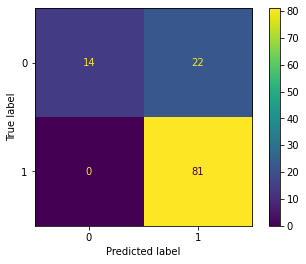

In [914]:
# LOGISTIC REGRESSION
# Plot Confusion Matrix

plot_confusion_matrix(model_lr, X_val, y_val, values_format='.0f');

# TN FP
# FN TP

In [915]:
# LOGISTIC REGRESSION
# Calculate Precision and Recall

# Precision = TP / (TP + FP)
precision = 81 / (81 + 22)

# Recall = TP / (TP + FN)
recall = 81 / (81 + 0)

print('Logistic Regression model precision: {:.2f}%'.format(precision*100))
print('Logistic Regression model recall: {:.2f}%'.format(recall*100))

Logistic Regression model precision: 78.64%
Logistic Regression model recall: 100.00%


In [916]:
# RANDOM FOREST CLASSIFIER, preformance
# Not very good precision for Y, great recall for Y

print('Random Forest Classifier')
print(classification_report(y_val, model_rf.predict(X_val)))

Random Forest Classifier
              precision    recall  f1-score   support

           0       0.80      0.44      0.57        36
           1       0.79      0.95      0.87        81

    accuracy                           0.79       117
   macro avg       0.80      0.70      0.72       117
weighted avg       0.80      0.79      0.77       117



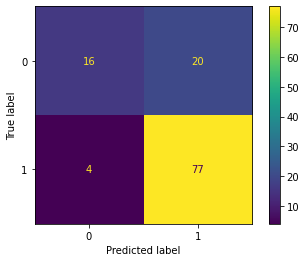

In [917]:
# RANDOM FOREST CLASSIFIER
# Plot Confusion Matrix

plot_confusion_matrix(model_rf, X_val, y_val, values_format='.0f');

# TN FP
# FN TP

In [919]:
# RANDOM FOREST CLASSIFIER 
# Calculate Precision and Recall

# Precision = TP / (TP + FP)
precision = 77 / (77 + 20)

# Recall = TP / (TP + FN)
recall = 77 / (77 + 4)

print('Random Forest Classifier precision: {:.2f}%'.format(precision*100))
print('Random Forest Classifier recall: {:.2f}%'.format(recall*100))

Random Forest Classifier precision: 79.38%
Random Forest Classifier recall: 95.06%


In [920]:
# XGBoost Classifier, preformance

print('XGBoost Classifier')
print(classification_report(y_val, model_xgb.predict(X_val)))

XGBoost Classifier
              precision    recall  f1-score   support

           0       0.84      0.44      0.58        36
           1       0.80      0.96      0.87        81

    accuracy                           0.80       117
   macro avg       0.82      0.70      0.73       117
weighted avg       0.81      0.80      0.78       117



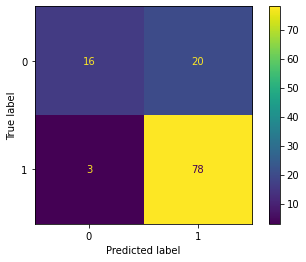

In [921]:
# XGBoost Classifier
# Plot Confusion Matrix

plot_confusion_matrix(model_xgb, X_val, y_val, values_format='.0f');

# TN FP
# FN TP

In [922]:
# XGBOOST CLASSIFIER 
# Calculate Precision and Recall

# Precision = TP / (TP + FP)
precision = 78 / (78 + 20)

# Recall = TP / (TP + FN)
recall = 78 / (78 + 3)

print('XGBoost Classifier precision: {:.2f}%'.format(precision*100))
print('XGBoost Classifier recall: {:.2f}%'.format(recall*100))

XGBoost Classifier precision: 79.59%
XGBoost Classifier recall: 96.30%


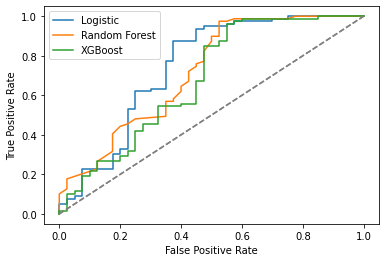

In [1021]:
# INCOME OUTLIERS NOT REMOVED
# Plot ROC curve to evaluate the models 
# 'How far up can I go without having to go too far to the right?'

lr = plot_roc_curve(model_lr, X_val, y_val, label='Logistic')
rf = plot_roc_curve(model_rf, X_val, y_val, ax=lr.ax_, label='Random Forest')
xgb = plot_roc_curve(model_xgb, X_val, y_val, ax=lr.ax_, label='XGBoost')
plt.plot([(0,0), (1,1)], color='grey', linestyle='--')
plt.legend();

In [1022]:
print('Logistic: ROA-AUC Score: {:.2f}%'.format(roc_auc_score(y_val, model_lr.predict(X_val))*100))
print('Random Forest: ROC-AUC Score:: {:.2f}%'.format(roc_auc_score(y_val, model_rf.predict(X_val))*100))
print('XGBoost: ROC-AUC Score:: {:.2f}%'.format(roc_auc_score(y_val, model_xgb.predict(X_val))*100))

Logistic: ROA-AUC Score: 69.98%
Random Forest: ROC-AUC Score:: 71.22%
XGBoost: ROC-AUC Score:: 67.42%


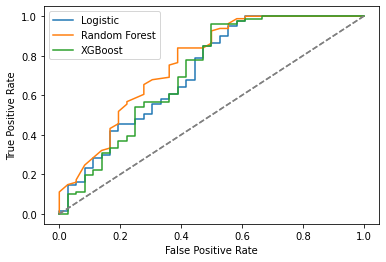

In [923]:
# INCOME OUTLIERS REMOVED

lr = plot_roc_curve(model_lr, X_val, y_val, label='Logistic')
rf = plot_roc_curve(model_rf, X_val, y_val, ax=lr.ax_, label='Random Forest')
xgb = plot_roc_curve(model_xgb, X_val, y_val, ax=lr.ax_, label='XGBoost')
plt.plot([(0,0), (1,1)], color='grey', linestyle='--')
plt.legend();

In [924]:
print('Logistic: ROA-AUC Score: {:.2f}%'.format(roc_auc_score(y_val, model_lr.predict(X_val))*100))
print('Random Forest: ROC-AUC Score:: {:.2f}%'.format(roc_auc_score(y_val, model_rf.predict(X_val))*100))
print('XGBoost: ROC-AUC Score:: {:.2f}%'.format(roc_auc_score(y_val, model_xgb.predict(X_val))*100))

Logistic: ROA-AUC Score: 69.44%
Random Forest: ROC-AUC Score:: 69.75%
XGBoost: ROC-AUC Score:: 70.37%


In [ ]:
# Not the greatest looking curves.

# VII. Tune Model & Recheck Metrics

In [925]:
# Let's look at the feature importances of our RF and XGBoost Classifier model.

# Random Forest Classifier
importances = model_rf.named_steps['randomforestclassifier'].feature_importances_
features = X_train.columns
feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp

self_employed         0.016080
gender                0.019379
education             0.019456
married               0.025057
loan_amount_term      0.026084
dependents            0.037052
property_area         0.054505
coapplicant_income    0.074824
loan_amount           0.130382
applicant_income      0.155213
loan_to_income        0.176076
credit_history        0.265893
dtype: float64

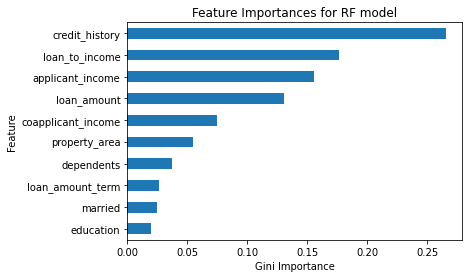

In [926]:
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Gini Importance')
plt.ylabel('Feature')
plt.title('Feature Importances for RF model')
plt.show()

In [927]:
# Let's permute the data - we'll shuffle the data in a column to create 
# noise-static.  We can see how much it previously helped the model's
# prediction by taking away it's predictive power.

perm_imp = permutation_importance(
    model_rf,
    X_val, # Always use your VALIDATION set
    y_val,
    n_jobs=-1,
    random_state=42
)

In [928]:
perm_imp.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [929]:
# Put results into a DataFrame
data = {'importances_mean': perm_imp['importances_mean'],
        'importances_std': perm_imp['importances_std']}

df = pd.DataFrame(data, index=X_val.columns)
df.sort_values(by='importances_mean', inplace=True)

In [930]:
df

,importances_mean,importances_std
property_area,-0.020513,0.006838
applicant_income,-0.015385,0.006396
coapplicant_income,-0.010256,0.009967
education,-0.006838,0.003419
gender,-0.003419,0.004187
dependents,0.000000,0.000000
loan_amount,0.001709,0.012561
self_employed,0.006838,0.003419
loan_amount_term,0.006838,0.006396
married,0.017094,0.012087


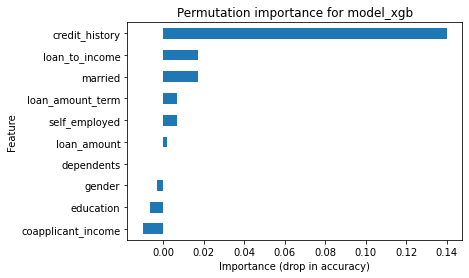

In [931]:
df['importances_mean'].tail(10).plot(kind='barh')
plt.xlabel('Importance (drop in accuracy)')
plt.ylabel('Feature')
plt.title('Permutation importance for model_xgb')
plt.show()

In [932]:
# XGBoost
importances = model_xgb.named_steps['xgbclassifier'].feature_importances_
features = X_train.columns
feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp

loan_amount           0.034179
dependents            0.041750
loan_to_income        0.043397
education             0.044032
coapplicant_income    0.044152
applicant_income      0.044589
gender                0.051480
married               0.053105
self_employed         0.056931
loan_amount_term      0.066758
property_area         0.072206
credit_history        0.447420
dtype: float32

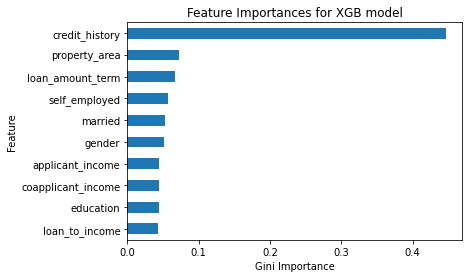

In [933]:
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Gini Importance')
plt.ylabel('Feature')
plt.title('Feature Importances for XGB model')
plt.show()

In [934]:
# Put results into a DataFrame
data = {'importances_mean': perm_imp['importances_mean'],
        'importances_std': perm_imp['importances_std']}

df = pd.DataFrame(data, index=X_val.columns)
df.sort_values(by='importances_mean', inplace=True)

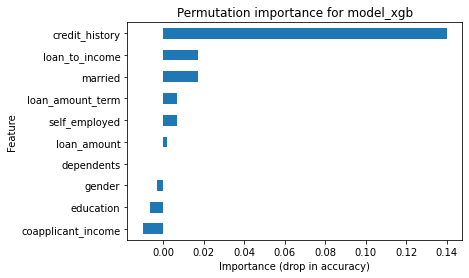

In [935]:
df['importances_mean'].tail(10).plot(kind='barh')
plt.xlabel('Importance (drop in accuracy)')
plt.ylabel('Feature')
plt.title('Permutation importance for model_xgb')
plt.show()

In [ ]:
# It looks like 'gender', 'education', and 'coapplicant_income' detract from the model's predictive power.
# Regarding 'coapplicant_income', I theorize that the no 0 incidated most frequently, may at times be due 
# households with a single income but two names on the note, or it may indicate that these loans were 
# made by a single person and it was filled with a zero. 

In [1056]:
# Training and Validation accuracy of our Logistic Regression model 

print('Training Accuracy (LOGR): {:.2f}%'.format(model_lr.score(X_train, y_train)*100))
print('Validation Accuracy (LOGR): {:.2f}%'.format(model_lr.score(X_val, y_val)*100))

Training Accuracy (LOGR): 82.19%
Validation Accuracy (LOGR): 80.34%


In [1057]:
# Training and Validation accuracy of our Random Forest Classifier model
# Performance improved

print('Training Accuracy(RF): {:.2f}%'.format(model_rf.score(X_train, y_train)*100))
print('Validation Accuracy (RF): {:.2f}%'.format(model_rf.score(X_val, y_val)*100))

Training Accuracy(RF): 100.00%
Validation Accuracy (RF): 80.34%


In [1058]:
# Training and Validation accuracy of our XGBoost Classifier model
# Performance improved

print('Training Accuracy(XGB): {:.2f}%'.format(model_xgb.score(X_train, y_train)*100))
print('Validation Accuracy (XGB): {:.2f}%'.format(model_xgb.score(X_val, y_val)*100))

Training Accuracy(XGB): 100.00%
Validation Accuracy (XGB): 81.20%


In [ ]:
# Let's try some hyperparameter tuning of the models. 

In [806]:
# Tune Logistic Regression Model

penalty_variants = ['l2', 'none']
solver_variants = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

# No effect witnessed with tuning of this hyperparameter
# for _ in penalty_variants:
#     model_lr_tune = make_pipeline(
#         OneHotEncoder(use_cat_names=True),
#         StandardScaler(),
#         LogisticRegression(penalty=_)
#     )
#     model_lr_tune.fit(X_train, y_train);
#     print(_, 'Validation Accuracy (LOGR_penalty_tuned):', model_lr.score(X_val, y_val), "\n")

# No effect witnessed with tuning of this hyperparameter
# for _ in range(1, 11):
#     model_lr_tune = make_pipeline(
#         OneHotEncoder(use_cat_names=True),
#         StandardScaler(),
#         LogisticRegression(C=_)
#     )
#     model_lr_tune.fit(X_train, y_train);
#     print(_, 'Validation Accuracy (LOGR_penalty_tuned):', model_lr.score(X_val, y_val), "\n")

# No effect witnessed with tuning of this hyperparameter
# for _ in solver_variants:
#     model_lr_tune = make_pipeline(
#         OneHotEncoder(use_cat_names=True),
#         StandardScaler(),
#         LogisticRegression(solver=_)
#     )
#     model_lr_tune.fit(X_train, y_train);
#     print(_, 'Validation Accuracy (LOGR_penalty_tuned):', model_lr.score(X_val, y_val), "\n")

In [1059]:
# Complete a RandomizedSearchCV for our RF model

params = {'randomforestclassifier__n_estimators': np.arange(20, 100, 5), 
          'randomforestclassifier__max_depth': np.arange(10, 75, 5),
          'randomforestclassifier__max_samples': np.arange(0.1, 0.99, 0.1)}

rf_rs = RandomizedSearchCV(model_rf, param_distributions=params, n_iter=10, cv=5, n_jobs=-1, verbose=1)

In [1060]:
rf_rs.fit(X_train, y_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.2s finished
/Users/frankhowd/.local/share/virtualenvs/DS-Unit-2-Applied-Modeling-YelssOLa/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [1061]:
# Score is imporoved to nearly 83%

rf_rs.best_score_

0.8219858156028369

In [1062]:
rf_rs.best_params_

{'randomforestclassifier__n_estimators': 85,
 'randomforestclassifier__max_samples': 0.30000000000000004,
 'randomforestclassifier__max_depth': 30}

In [1063]:
# Model 2: Random Forest Classifier Model with best params

model_rf = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier(n_estimators=85, max_samples=0.3, max_depth=30,
                           n_jobs=-1, random_state=42)
)

model_rf.fit(X_train, y_train);

In [1064]:
# Training and Validation accuracy of our Random Forest Classifier model

print('Training Accuracy(RF): {:.2f}%'.format(model_rf.score(X_train, y_train)*100))
print('Validation Accuracy (RF): {:.2f}%'.format(model_rf.score(X_val, y_val)*100))

Training Accuracy(RF): 87.98%
Validation Accuracy (RF): 82.91%


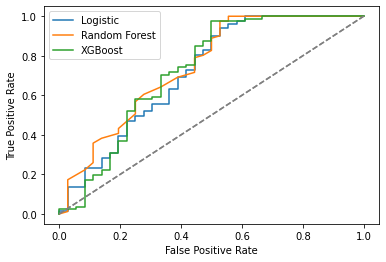

In [1041]:
# Final ROC curve

lr = plot_roc_curve(model_lr, X_val, y_val, label='Logistic')
rf = plot_roc_curve(model_rf, X_val, y_val, ax=lr.ax_, label='Random Forest')
xgb = plot_roc_curve(model_xgb, X_val, y_val, ax=lr.ax_, label='XGBoost')
plt.plot([(0,0), (1,1)], color='grey', linestyle='--')
plt.legend();

In [1042]:
print('Logistic: ROA-AUC Score: {:.2f}%'.format(roc_auc_score(y_val, model_lr.predict(X_val))*100))
print('Random Forest: ROC-AUC Score:: {:.2f}%'.format(roc_auc_score(y_val, model_rf.predict(X_val))*100))
print('XGBoost: ROC-AUC Score:: {:.2f}%'.format(roc_auc_score(y_val, model_xgb.predict(X_val))*100))

Logistic: ROA-AUC Score: 68.83%
Random Forest: ROC-AUC Score:: 70.99%
XGBoost: ROC-AUC Score:: 72.53%
